In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import os
#import glob
from pandas import DataFrame
from pandas.io.parsers import TextFileReader
from sklearn import metrics
from sklearn.metrics import roc_curve,auc

In [43]:
gau = pd.read_csv('./result/result_matrix_ie_gau.txt',sep='\t',index_col=0,header=0)
exp = pd.read_csv('./result/result_matrix_ie_toni_exp.txt',sep='\t',index_col=0,header=0)
path = pd.read_csv('./result/result_matrix_ie_toni_path.txt',sep='\t',index_col=0,header=0)
seq = pd.read_csv('./result/result_matrix_ie_seq.txt',sep='\t',index_col=0,header=0)
tf = pd.read_csv('./result/result_matrix_ie_ld_tf.txt',sep='\t',index_col=0,header=0)
gene = pd.read_csv('./result/result_matrix_ie_ld_gene.txt',sep='\t',index_col=0,header=0)

In [44]:
MS = 0.15*seq+0.1*exp+0.05*gau+0.25*path+0.2*gene+0.25*tf

In [45]:
MS.to_csv("./result/Result_matrix.txt", sep="\t", index=True,header=True)

In [46]:
Prediction = MS
miRNA=pd.read_csv("./data/all_mirna.txt", sep="\t",header=None)
disease=pd.read_csv("./data/all_disease.txt", sep="\t",header=None)
file = open("result/Result_score.txt","w")
for x in range(len(miRNA)):
    for y in range(len(disease)):
        file.write(str(x)+"\t"+str(y)+"\t"+miRNA.iloc[x,1]+"\t"+disease.iloc[y,1]+"\t"+str(Prediction.iloc[x,y])+"\n")
file.close()

#### 区分因果和非因果的ROC

In [47]:
causal = pd.read_csv("./data/yanzheng2.txt", header=None, delimiter="\t",names=["causal","mir","dis","yn",])

In [48]:
result = pd.read_csv("result/Result_score.txt", header=None, delimiter="\t",names=["nmir","ndis","mir","dis","prediction"])

In [49]:
result

,nmir,ndis,mir,dis,prediction
0,0,0,hsa-let-7a,Acute Kidney Injury,0.021357
1,0,1,hsa-let-7a,Acute Lung Injury,0.003810
2,0,2,hsa-let-7a,Adenoviridae Infections,0.005168
3,0,3,hsa-let-7a,Adrenal Cortex Neoplasms,0.013591
4,0,4,hsa-let-7a,Adrenocortical Carcinoma,0.014532
...,...,...,...,...,...
161565,534,297,hsa-mir-99b,Vascular System Injuries,0.003173
161566,534,298,hsa-mir-99b,Waldenstrom Macroglobulinemia,0.007863
161567,534,299,hsa-mir-99b,Wilms Tumor,0.008144
161568,534,300,hsa-mir-99b,Wound Healing,0.002771


In [50]:
c_result = pd.merge(result,causal,on=['mir','dis'],how = 'left')
r = c_result[["mir","dis","prediction","causal"]]
r2 = r.fillna(3)
r2.to_csv("./result/Result_causal_for_ROC.txt", sep="\t", index=False,header=False)

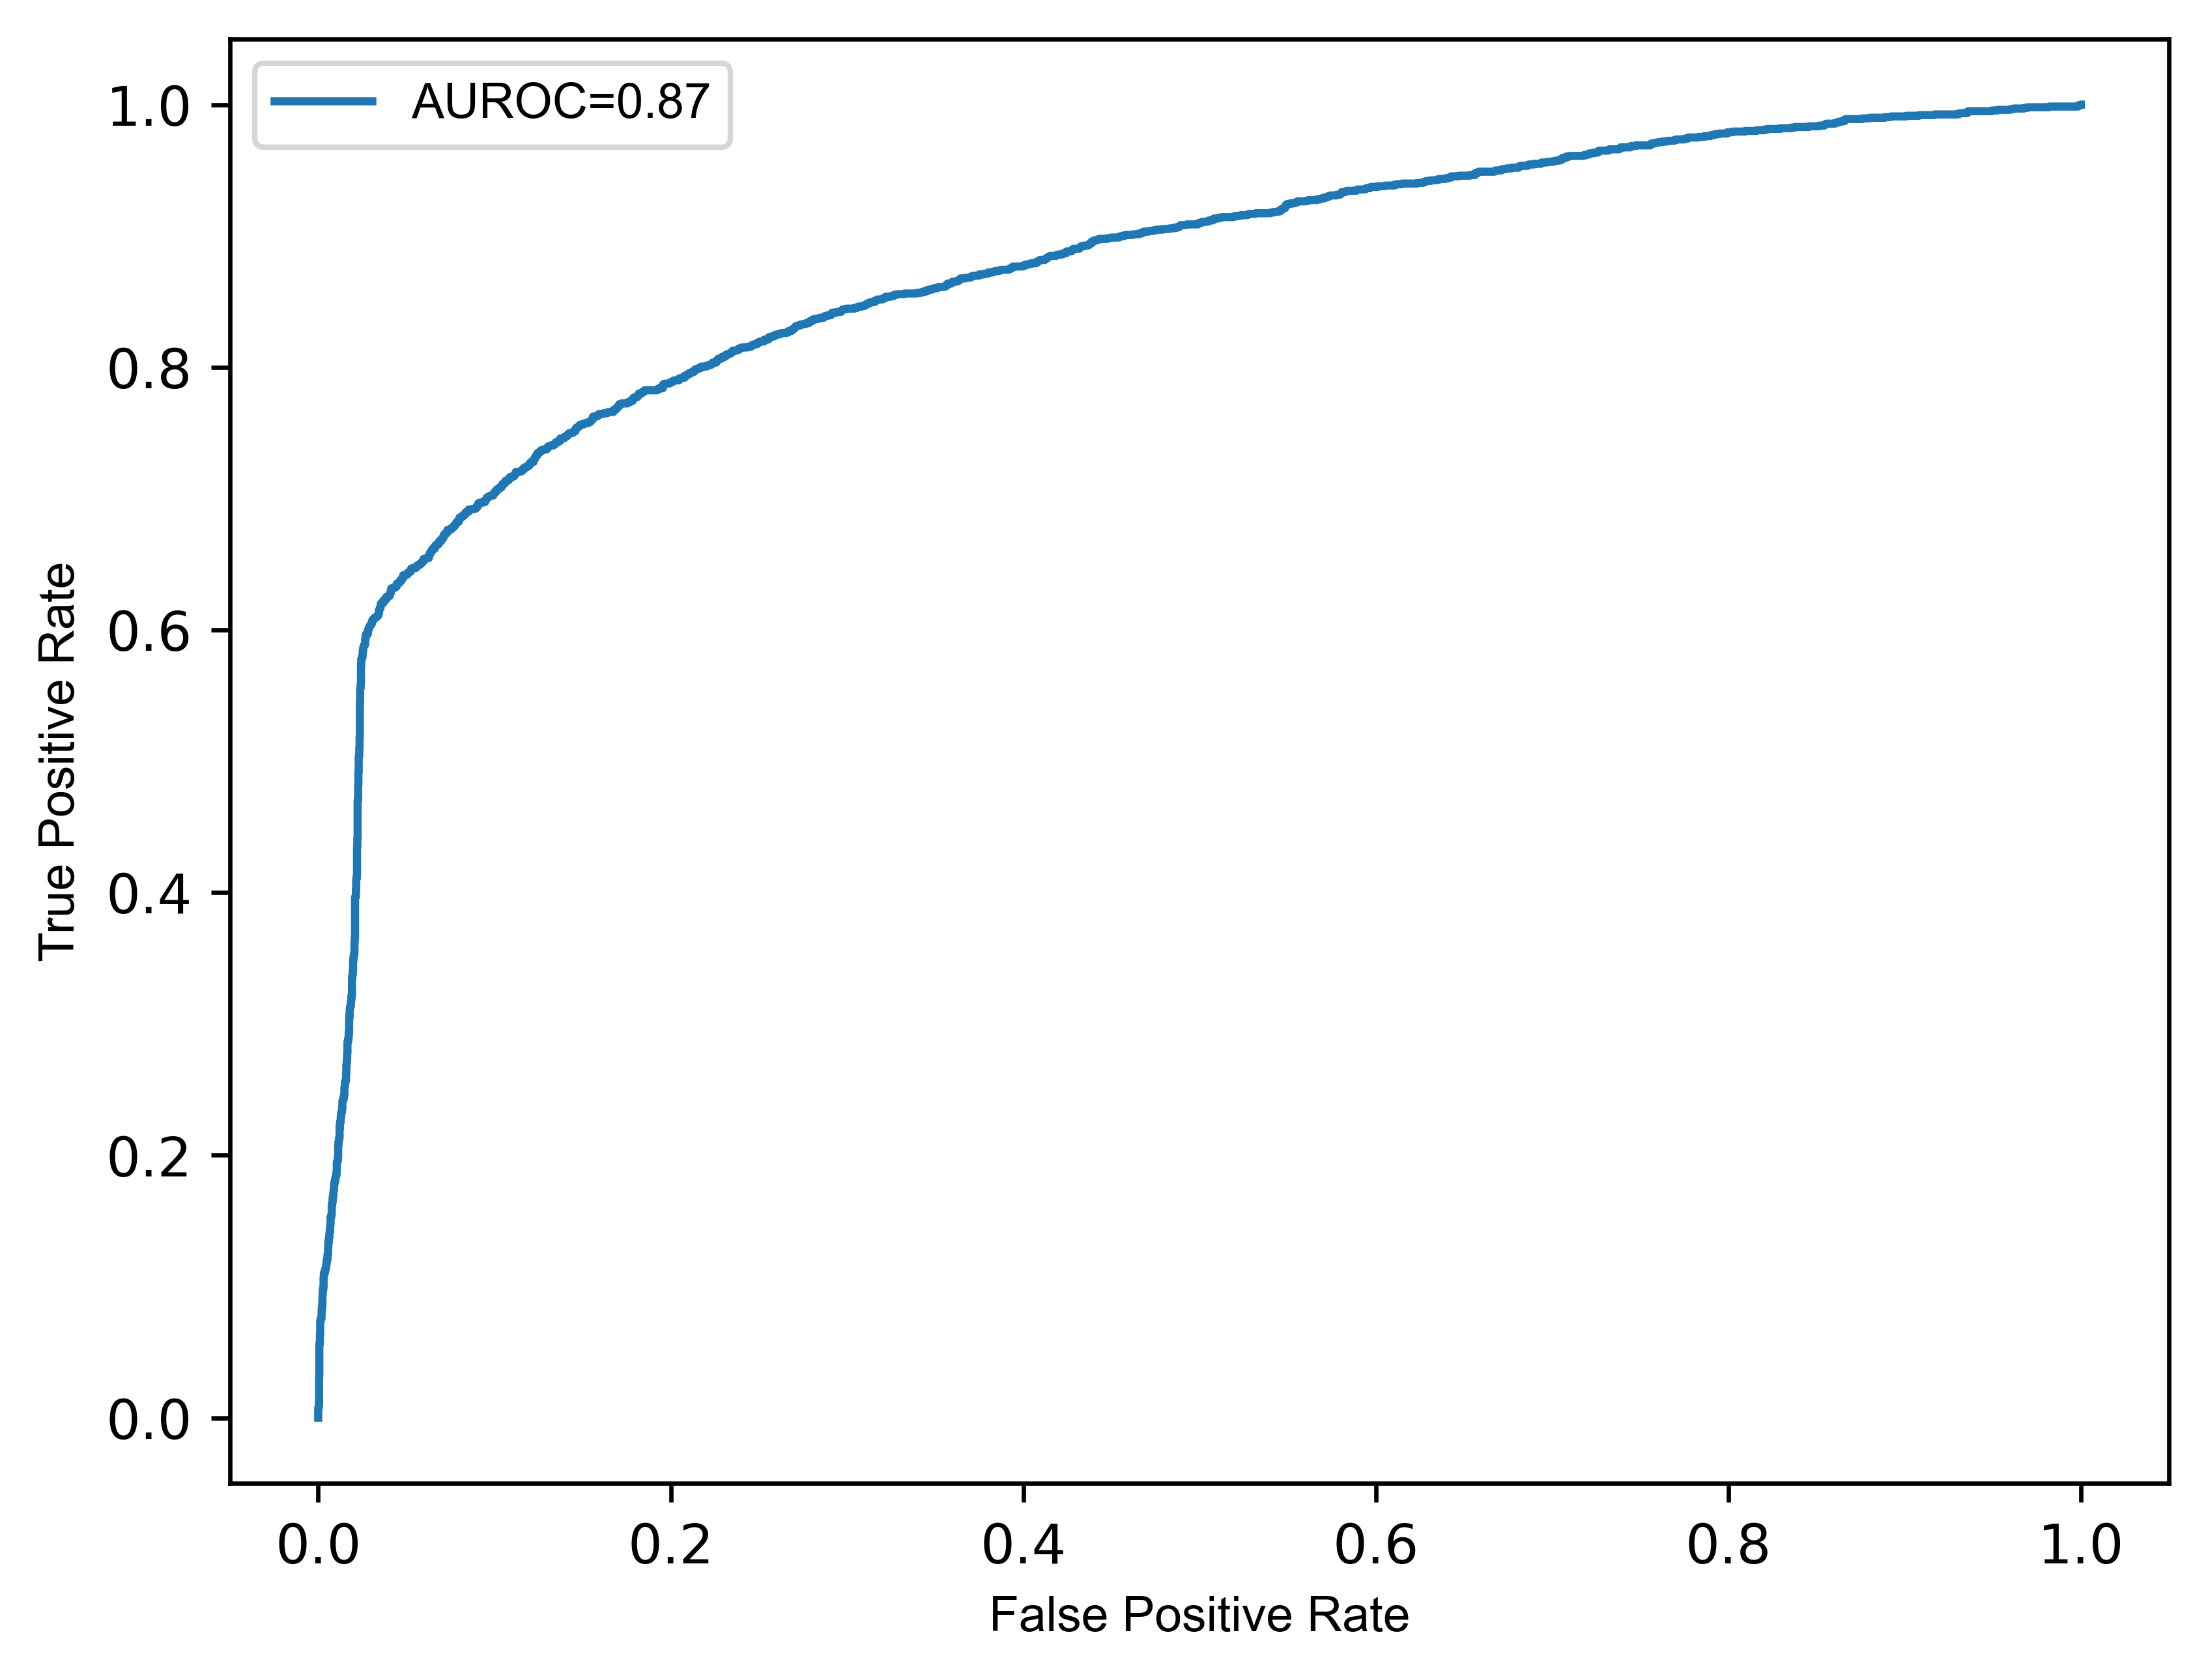

0.8699618264161201


In [51]:
plt.rcParams['figure.dpi'] = 600
plt.figure(1)
font1 = {"family":"Arial",
         "weight":"book",
         "size": 9
         }
#plt.title('ROC Curve',font1)
plt.xlabel('False Positive Rate',font1)
plt.ylabel('True Positive Rate',font1)
# Names = ["L1-norm","TLHNMDA","CNMDA","RWBRMDA","HGIMDA","HLPMDA","HNMDA","MDHGI","IMCMDA","RFMDA"]
'''for path in PathList:
    FileName = os.path.basename(path).split("_")[0]'''
data = pd.read_csv("./result/Result_causal_for_ROC.txt", header=None, delimiter="\t", names=["mir","dis","y_scores","causality"])
#data = data.drop_duplicates(subset=["disease", "miRNA", "y_scores"], keep="first")
data = data.loc[data["causality"] != 3]
y_true = np.array(data.iloc[:,3])
y_true = np.where(y_true == 1,True,False)
y_scores = np.array(data.iloc[:,2])
area = 0
fpr,tpr,threshold = roc_curve(y_true,y_scores)
area = metrics.auc(fpr,tpr)
auc = round(area, 3)
#file = open("ROC.txt","a")
#file.write("causal"+"\t"+str(area)+"\n")
plt.figure(1)
plt.plot(fpr, tpr, label="AUROC=" + str(auc))
plt.legend(prop=font1)
#plt.savefig("./Result_causal_for_ROC_10_fold_mean.tiff",dpi = 600)
plt.show()
plt.close()
#file.close()
print(str(area))

#### 区分因果和无关对的独立测试ROC值

In [52]:
testset =  pd.read_csv("./data/hmdd_causal_test.txt",sep="\t",header= None)
trainset =  pd.read_csv("./data/hmdd_causal_train.txt",header = None,sep="\t")

In [53]:
trainset.columns = ['mir','dis','cau']
testset.columns = ['mir','dis','cau']

In [54]:
Score = pd.read_csv("result/Result_score.txt", header=None, sep="\t")
Score.columns = ['nmir','ndis','mir','dis','pred']
a = pd.merge(Score,testset,on=['mir','dis'],how = 'left')
b = a.fillna(0)
b.to_csv("result/Result_for_independent_test_ROC_non_disease.txt", sep="\t", index=False,header=False)

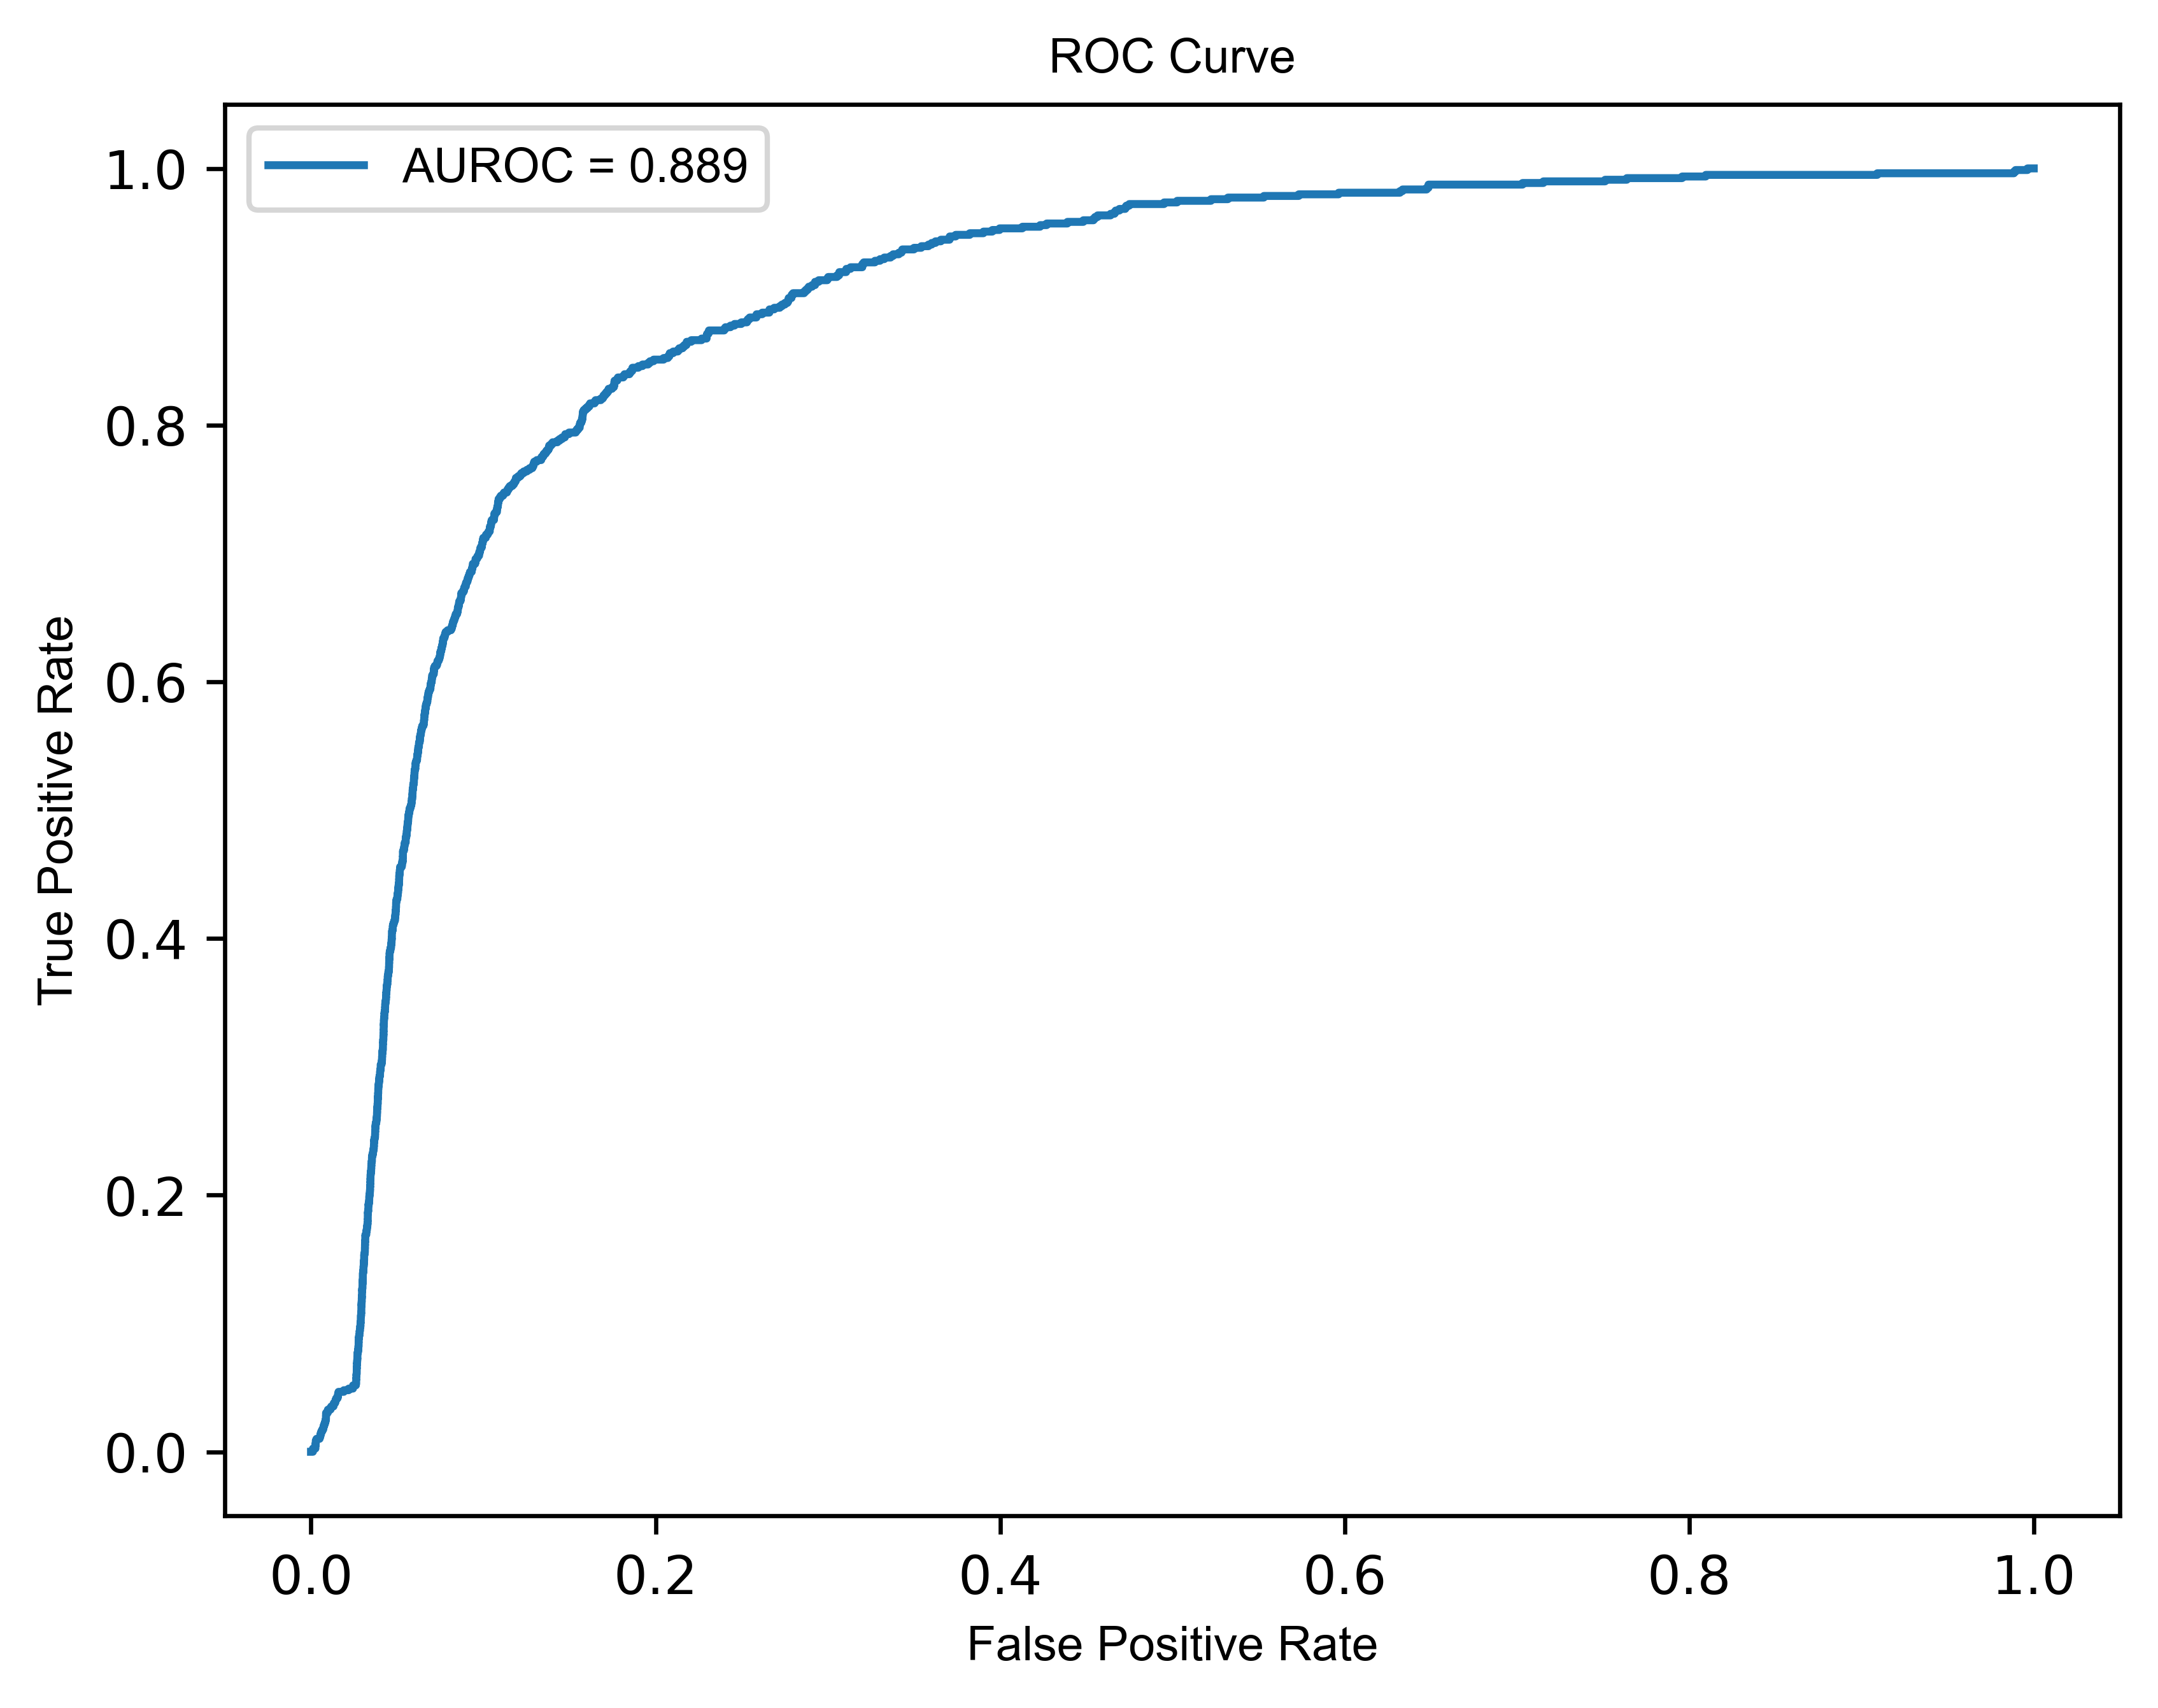

In [55]:
plt.rcParams['figure.dpi'] = 600
plt.figure(1)
font1 = {"family":"Arial",
            "weight":"book",
            "size": 9
            }
plt.title('ROC Curve',font1)
plt.xlabel('False Positive Rate',font1)
plt.ylabel('True Positive Rate',font1)

data = pd.read_csv("result/Result_for_independent_test_ROC_non_disease.txt", header=None, delimiter="\t",names=["nmir","ndis","miRNA","disease","prediction","causal"])  # type: Union[Union[TextFileReader, DataFrame], Any]
causal = np.array(data.iloc[:,5])
casual = np.where(causal == 1,True,False)
prediction = np.array(data.iloc[:,4])
area = 0
fpr,tpr,threshold = roc_curve(casual,prediction)
area = metrics.auc(fpr,tpr)
auc = round(area, 3)
#file = open("ROC.txt","a")
#file.write('independent'+"\t"+str(area)+"\n")
plt.figure(1)
plt.plot(fpr, tpr, label="AUROC = " + str(auc))
plt.legend(prop=font1)
#plt.savefig("./independent_ROC_curve.tiff",dpi = 600)
plt.show()
plt.close()
#file.close()